# Introduction

## About

This notebook gathers the code used for the miniproject "Bayesian Inverse Problems in Large Dimensions" of the Stochastic Simulation course. See the report for theoretical details.

## Setup

In [1]:
# Google Colab compatibility
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/mcmc-inverse-bayesian
except ModuleNotFoundError:
    pass

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Standard libraries
from glob import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [38]:
# Override matplotlib defaults for nicer plots
sns.set(style='whitegrid')
# Make plots more latex-like looking
matplotlib.rcParams.update({
    'backend': 'ps',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{gensymb}',
})

In [39]:
def process_figure(filename):
    """Prettify figure (e.g. despine and make it latex-like) and save it to file"""
    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')

In [4]:
# Custom imports
from utils import G, target_density
from mcmc import rwmh, diagnose_plot
from utils import dump_simulation_results, load_simulation_results

In [5]:
# Given data
y = np.array([0.5041, 0.8505, 1.2257, 1.4113])

In [6]:
# Noise standard deviation
sigma_noise = 0.04
# Chain length
N = int(1e4)

# Random Walk Metropolis

In this first approach, we use the proposal distribution

$$Q(\mathbf \theta, \cdot) = \mathcal N(\mathbf \theta, s^2 C), \quad C = \text{diag}(1, 2^{-2}, \ldots, D^{-2})$$

where $D$ is the dimension of the state space, being the number of Fourier coefficients used to approximate the log-permeability.

The goal is to generate chains of length $N=10^4$ with different values of $s$ and $D$. Remind that we're trying to probe the efficiency of MCMC for $D \to\infty$. We will use the `rwmh` (Random Walk Metropolis Hastings) utility function:

In [7]:
help(rwmh)

Help on function rwmh in module mcmc:

rwmh(ftilde: Callable, variances: numpy.ndarray, X0: numpy.ndarray, N: int, precond_const: float = 1.0, verbose: bool = True)
    Random Walk Metropolis Hastings, i.e. type of Markov Chain Monte Carlo in continuous state space with Gaussian proposal
    density centered at current state.
    For a multidimensional state space, the components of the proposal samples are independent, i.e. the covariance
    matrix is diagonal.
    :param ftilde: un-normalized target density being the Markov Chain invariant distribution (after normalization)
    :param variances: 1D array of variances for each component of the proposal distribution
    :param X0: starting point of the chain
    :param N: chain length
    :param precond_const: constant for preconditionned Crank-Nicholson, e.g. sqrt(1 - s^2)
    :return: Markov Chain of length N



In [8]:
def simulate(args):
    """Perform one simulation, used as map function for multiprocessor pool"""
    D, s = args
    print(f'D = {D}, s = {s}\t', end='')
    X, p_accept = rwmh(
        ftilde=lambda theta: target_density(theta, sigma_noise, y),
        variances=s**2 / np.arange(1, D+1)**2,
        X0=np.zeros(D),
        N=N
    )
    # Only return the first component of the chain, too much data otherwise
    return {
        'X': X[:, 0],
        'D': D,
        's': s,
        'p_accept': p_accept
    }

In [9]:
import multiprocessing as mp
import itertools

One can typically run the cell below in Google Colab with appropriate values for `s` and `D` and then import results with `load_simulation_results`:

In [10]:
# D = (10, 100, 1000)
# s = (0.05, 0.1, 0.15, 0.2, 0.3, 0.5)
# pool = mp.Pool(mp.cpu_count())
# data = pool.map(simulate, itertools.product(D, s))
# pool.close()
# dump_simulation_results(data, 'data/rwmh_1.json.gz')

In [45]:
df = pd.concat([
    pd.DataFrame(load_simulation_results(fpath)) for fpath in glob('data/rwmh_*.json.gz')
]).reset_index(drop=True).sort_values(['D', 's'])
df

,X,D,s,p_accept
0,"[0.0, 0.06016228464499908, 0.04784292988217376...",10,0.050,0.884888
1,"[0.0, 0.0, 0.16016005545099146, 0.160160055450...",10,0.100,0.750875
2,"[0.0, 0.2010949446929186, 0.39952787712380605,...",10,0.150,0.640164
3,"[0.0, 0.2406491385799963, 0.19137171952869506,...",10,0.200,0.546555
4,"[0.0, 0.0, 0.48048016635297436, 0.480480166352...",10,0.300,0.374037
5,"[0.0, 0.6703164823097287, 0.6703164823097287, ...",10,0.500,0.182718
6,"[0.0, -0.01573369801579178, 0.0525382163241156...",100,0.050,0.772477
7,"[0.0, -0.06524551001312011, 0.0344925739425354...",100,0.100,0.566857
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.16608198721236725,...",100,0.150,0.394239
9,"[0.0, 0.0, 0.2730876573596296, 0.2730876573596...",100,0.200,0.253225


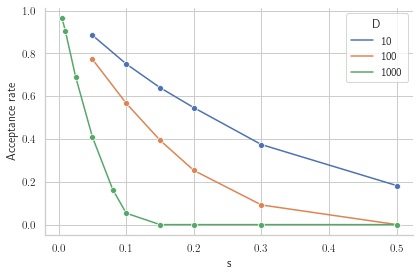

In [47]:
palette = sns.color_palette(n_colors=df.D.nunique())
sns.lineplot(x='s', y='p_accept', hue='D', data=df, marker='o', palette=palette)
plt.ylabel('Acceptance rate')
process_figure('figs/1_rwmh_overview.pdf')

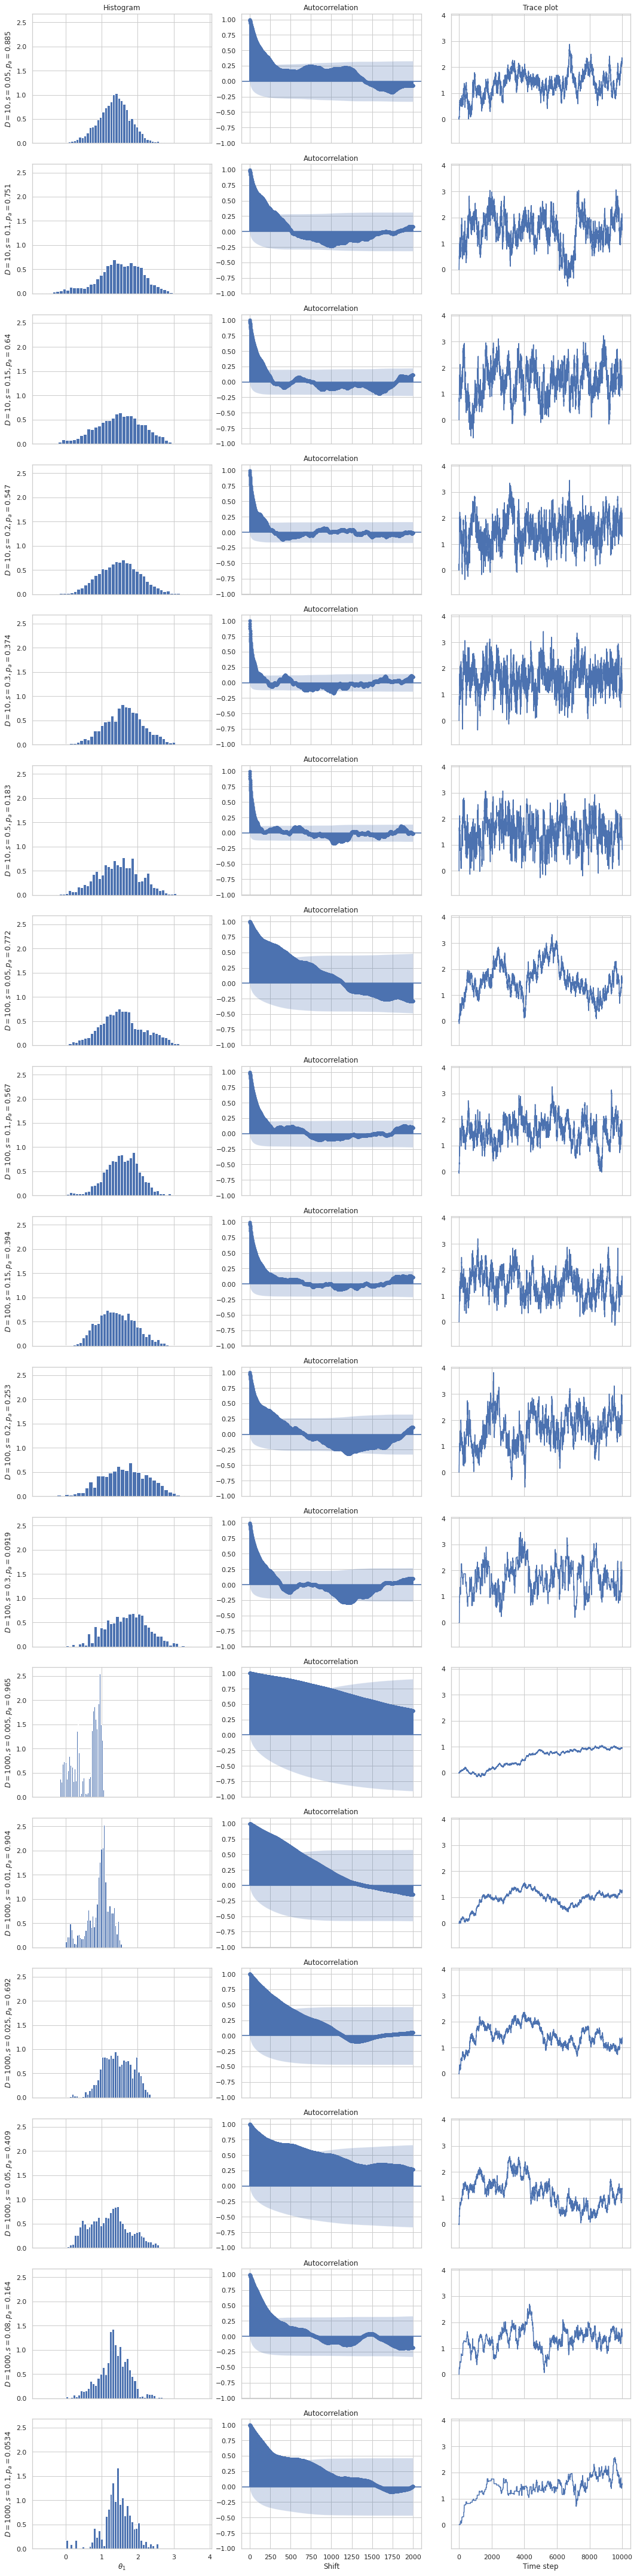

In [15]:
df_diagnosis = df[(df.p_accept > 0.01)]
labels = [
    f'$D = {row.D}, s = {row.s}, p_a = {row.p_accept:.3}$' for _, row in df_diagnosis.iterrows()
]
diagnose_plot(df_diagnosis.X, labels, r'$\theta_1$')

In [ ]:
# data = []
# for D in (100,):
#     for s in (0.1, 0.3):
#         X, p_accept = rwmh(
#             ftilde=lambda theta: target_density(theta, sigma_noise, y),
#             variances=s**2 / np.arange(1, D+1)**2,
#             X0=np.zeros(D),
#             N=N
#         )
#         data.append({
#             'X': X,
#             'D': D,
#             's': s,
#             'p_accept': p_accept
#         })
#
# dump_simulation_results(data, 'data/rwmh_1.json.gz')

# Improvement: Preconditionned Crank-Nicholson

We modify the proposal distribution: the mean of the Gaussian is now biased toward zero:

$$q(\mathbf \theta, \cdot) = \mathcal N(\mathbf \theta \sqrt{1-s^2}, s^2 C)$$

In terms of the implementation, only a slight modification of `rwmh` is required: we just add a `precond_const` argument with value `1.0` by default (i.e., standard random walk metropolis), and we multiply the current state by this `precond_const` when shifting the pre-computed proposals.

In [15]:
from mcmc import pcn

In [25]:
def simulate(args):
    """Perform one simulation, used as map function for multiprocessor pool"""
    D, s = args
    print(f'D = {D}, s = {s}\t', end='')
    X, p_accept = pcn(
        ftilde=lambda theta: np.exp(- 0.5 / sigma_noise**2 * ((y - G(theta)) ** 2).sum()),
        variances=s**2 / np.arange(1, D+1)**2,
        X0=np.zeros(D),
        N=N,
        factor=np.sqrt(1 - s**2)
    )
    # Only return the first component of the chain, too much data otherwise
    return {
        'X': X[:, 0],
        'D': D,
        's': s,
        'p_accept': p_accept
    }

In [26]:
D = (10, 100, )
s = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
pool = mp.Pool(mp.cpu_count())
data = pool.map(simulate, itertools.product(D, s))
pool.close()
dump_simulation_results(data, 'data/pcn_1.json.gz')

D = 10, s = 0.4	D = 10, s = 0.5	D = 10, s = 0.1	D = 10, s = 0.2	D = 10, s = 0.6	D = 10, s = 0.3	took 0.95 s   acceptance rate 0.45
took 0.986 s  acceptance rate 0.183D = 10, s = 0.7	
D = 10, s = 0.8	took 1.23 s   acceptance rate 0.613took 1.24 s   acceptance rate 0.798

D = 10, s = 0.9	took 1.27 s   acceptance rate 0.246D = 100, s = 0.1	
D = 100, s = 0.2	took 1.37 s   acceptance rate 0.332
D = 100, s = 0.3	took 0.935 s  acceptance rate 0.13
D = 100, s = 0.4	took 1.0 s    acceptance rate 0.0843
D = 100, s = 0.5	took 0.988 s  acceptance rate 0.0539
D = 100, s = 0.6	took 6.61 s   acceptance rate 0.426
D = 100, s = 0.7	took 6.86 s   acceptance rate 0.59
D = 100, s = 0.8	took 6.47 s   acceptance rate 0.326
D = 100, s = 0.9	took 7.5 s    acceptance rate 0.776
took 6.83 s   acceptance rate 0.235
took 6.68 s   acceptance rate 0.167
took 6.0 s    acceptance rate 0.12
took 5.97 s   acceptance rate 0.0811
took 5.9 s    acceptance rate 0.0544


In [42]:
D = (1000,)
s = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
pool = mp.Pool(mp.cpu_count())
data = pool.map(simulate, itertools.product(D, s))
pool.close()
dump_simulation_results(data, 'data/pcn_2.json.gz')

D = 1000, s = 0.3	D = 1000, s = 0.2	D = 1000, s = 0.1	D = 1000, s = 0.5	D = 1000, s = 0.4	D = 1000, s = 0.6	took 2.93e+02 s acceptance rate 0.233
D = 1000, s = 0.7	took 2.96e+02 s acceptance rate 0.172
D = 1000, s = 0.8	took 2.98e+02 s acceptance rate 0.783
D = 1000, s = 0.9	took 3e+02 s  acceptance rate 0.594
took 3e+02 s  acceptance rate 0.328
took 3.05e+02 s acceptance rate 0.444
took 2.68e+02 s acceptance rate 0.127
took 2.67e+02 s acceptance rate 0.0877
took 2.65e+02 s acceptance rate 0.0573


In [43]:
df = pd.concat([
    pd.DataFrame(load_simulation_results(fpath)) for fpath in glob('data/pcn_*.json.gz')
]).reset_index(drop=True).sort_values(['D', 's'])
df

,X,D,s,p_accept
0,"[0.0, -0.05706460480606407, -0.010008987972673...",10,0.100,0.798480
1,"[0.0, 0.0, 0.09353915382562836, 0.414863829618...",10,0.200,0.613461
2,"[0.0, 0.0, 0.14030873073844252, 0.618667824273...",10,0.300,0.450445
3,"[0.0, 0.0, 0.18707830765125671, 0.817889202100...",10,0.400,0.332033
4,"[0.0, 0.0, 0.23384788456407088, 1.010554584854...",10,0.500,0.246425
5,"[0.0, 0.0, 0.28061746147688504, 1.194137620622...",10,0.600,0.182818
6,"[0.0, 0.910054614014144, 0.910054614014144, 1....",10,0.700,0.129713
7,"[0.0, 1.0400624160161647, 1.0400624160161647, ...",10,0.800,0.084308
8,"[0.0, 1.1700702180181852, 1.1700702180181852, ...",10,0.900,0.053905
9,"[0.0, 0.13000780200202058, 0.15895069357256908...",100,0.100,0.775878


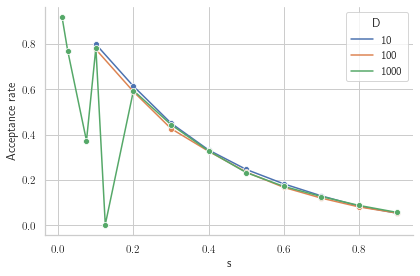

In [44]:
palette = sns.color_palette(n_colors=df.D.nunique())
sns.lineplot(x='s', y='p_accept', hue='D', data=df, marker='o', palette=palette)
plt.ylabel('Acceptance rate')
process_figure('figs/pcn_overview.pdf')

In [ ]:
df_diagnosis = df[df.p_accept > 0.01]
